In [1]:
import gzip 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps

%cd "/data/groups/ag_kircher/"


/fast/home/groups/ag_kircher


In [2]:
sample = 'IH01'

# Load fft, coverage, wps data 

In [10]:
##load fft summary
fft = pd.read_csv("cfDNA-reanalysis_Graz/kristin/rf_model/%s/fft_normalised.tsv" %sample, header = 0, sep = "\t", index_col = 0) 
#fft = fft[['205','202','199','196','193','190','187','185','182','180','177','175','173','170','168','166']]

##load coverage -1kb to 1kb around TSS
coverage = pd.read_csv("cfDNA-reanalysis_Graz/kristin/rf_model/%s/cov_normalised.tsv" %sample, sep = '\t', header = None, index_col = 0)

##load wps -1kb to 1kb around TSS
wps = pd.read_csv("cfDNA-reanalysis_Graz/kristin/rf_model/%s/wps_normalised.tsv" %sample, sep = '\t',header = None, index_col = 0)


# Load and filter expression data 

In [4]:
##load monocyte expression data 
expressionData = pd.read_csv("cfDNA-reanalysis_Graz/kristin/cfDNA/resources/protein_atlas/RNAtableExtended.tsv.gz", index_col = 0 ,compression = "gzip", header = 0, sep = "\t")
expressionMonocyte = expressionData[['monocytes']]


In [5]:
##load genes with high IQR 
genesHighIqr = pd.read_csv("cfDNA-reanalysis_Graz/kristin/GenesHighIQR.tsv", header = 0, sep = "\t")
genesHighIqr.index = genesHighIqr["GeneID"]
genesHighIqr = genesHighIqr.drop("GeneID", axis = 1)

In [6]:
#log transform expression values
LogExpressionMonocyte = expressionMonocyte.copy()
LogExpressionMonocyte['monocytes'] = np.log2(LogExpressionMonocyte['monocytes'] + 1)

In [7]:
import matplotlib.pyplot as plt


Expressed = LogExpressionMonocyte[(LogExpressionMonocyte.monocytes > 0.75)]
NotExpressed = LogExpressionMonocyte[(LogExpressionMonocyte.monocytes <= 0.75)].sample(frac = 0.2, random_state = 1)

LogExpressionFiltered = Expressed.append(NotExpressed)


# Merge datasets by gene ids 

In [8]:
union = LogExpressionFiltered.index.intersection(genesHighIqr.index).intersection(fft.index)


In [11]:
##filter high iqr genes ids 

LogExpressionFilteredIQR = LogExpressionFiltered.loc[union]

fft = fft.loc[union]
coverage = coverage.loc[union]
wps = wps.loc[union]


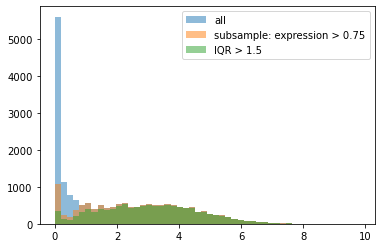

In [12]:
plt.hist(LogExpressionMonocyte, alpha = 0.5, bins = 50, label = "all")
plt.hist(LogExpressionFiltered['monocytes'], alpha = 0.5, bins = 50, label = "subsample: expression > 0.75")
plt.hist(LogExpressionFilteredIQR['monocytes'], alpha = 0.5, bins = 50, label = "IQR > 1.5")
plt.legend(loc='upper right')
plt.show()

# Calculate features

## Mean, median, variance

In [ ]:
##generate dataframe with features

features = fft.copy()

features['mean_cov_body1kb'] = coverage.loc[:,1000:2000].mean(axis = 1)
features['median_cov_body1kb'] = coverage.loc[:,1000:2000].median(axis = 1)
features['var_cov_body1kb'] = coverage.loc[:,1000:2000].var(axis = 1)
features['mean_cov_upstream1kb'] = coverage.loc[:,0:1000].mean(axis = 1)
features['median_cov_upstream1kb'] = coverage.loc[:,0:1000].median(axis = 1)
features['var_cov_upstream1kb'] = coverage.loc[:,0:1000].var(axis = 1)

features['variance_cov_2k'] = coverage.loc[:,0:2000].var(axis = 1)
features['mean_cov_2k'] = coverage.loc[:,0:2000].mean(axis = 1)
features['median_cov_2k'] = coverage.loc[:,0:2000].median(axis = 1)

features['mean_wps_body1kb'] = wps.loc[:,1000:2000].mean(axis = 1)
features['median_wps_body1kb'] = wps.loc[:,1000:2000].median(axis = 1)
features['var_wps_body1kb'] = wps.loc[:,1000:2000].var(axis = 1)

features['mean_wps_upstream1kb'] = wps.loc[:,0:1000].mean(axis = 1)
features['median_wps_upstream1kb'] = wps.loc[:,0:1000].median(axis = 1)
features['var_wps_upstream1kb'] = wps.loc[:,0:1000].var(axis = 1)

features['variance_wps_2k'] = wps.loc[:,0:2000].var(axis = 1)
features['mean_wps_2k'] = wps.loc[:,0:2000].mean(axis = 1)
features['median_wps_2k'] = wps.loc[:,0:2000].median(axis = 1)


## Amplitudes, ndr width 

In [191]:
wps_2k_smoothed = wps.copy()

for gene in wps_2k_smoothed.index: 
    wps_2k_smoothed.loc[gene] = sps.savgol_filter(wps_2k.loc[gene], window_length = 65, polyorder = 3)

In [192]:
wps_2k_smoothed.to_csv('cfDNA-reanalysis_Graz/kristin/rf_model/%s/table_WPS_2k_smoothed.csv' %sample, sep = '\t', header = True)

In [ ]:
wps_2k_smoothed = pd.read_csv("cfDNA-reanalysis_Graz/kristin/rf_model/%s/table_WPS_2k_smoothed.csv" %sample, sep = "\t", index_col = 0, header = 0) 

In [ ]:
wps_2k_smoothed.columns = list(range(1,2002))

In [ ]:
features['amp1'] = 0
features['amp2'] = 0 
features['ndr_width1'] = 0
features['ndr_width2'] = 0 

In [ ]:
import numpy as np
import math

for gene in wps_2k_smoothed.index:
    
    ##calculate amplitudes
    row = wps_2k_smoothed.loc[gene,1000:2000]

    maxima = np.array(sps.argrelextrema(np.array(row), comparator = np.greater, order = 50)).flatten()
    minima = np.array(sps.argrelextrema(np.array(row), comparator = np.less, order = 50)).flatten()
 
    amp1 = max(row.iloc[maxima[0]] - row.iloc[minima[0]], row.iloc[minima[0]] - row.iloc[maxima[0]])
    amp2 = max(row.iloc[maxima[1]] - row.iloc[minima[1]], row.iloc[minima[1]] - row.iloc[maxima[1]])
    
    features.loc[gene,'amp1'] = amp1
    features.loc[gene,'amp2'] = amp2
    
    ##calculate peak distances 
    row = wps_2k_smoothed.loc[gene,]
    
    max_peaks = np.array(sps.argrelextrema(np.array(row), comparator = np.greater, order = 50)).flatten()
    peak1_upstream = max(list(filter(lambda x: x < 1000, max_peaks)))
    peak1_body = min(list(filter(lambda x: x > 1000, max_peaks)))
    peak2_body = list(filter(lambda x: x > 1000, max_peaks))[1]

    features.loc[gene, 'ndr_width1'] = int(peak1_body) - int(peak1_upstream)
    features.loc[gene, 'ndr_width2'] = int(peak2_body) - int(peak1_upstream)

# Save features 

In [62]:
features['monocytes'] = LogExpressionFilteredIQR

In [65]:
features.to_csv('cfDNA-reanalysis_Graz/kristin/rf_model/%s/features.csv' %sample, sep = '\t', header = True)